# Read and explore the dataset. (Rename column, plot histograms, find data characteristics) 

In [55]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt


In [56]:
file_user='ratings_Electronics.csv'
u_cols = ['user_id', 'prod_id','rating',"timestamp"]

rating_df=pd.read_csv(file_user, names=u_cols)
rating_df.drop('timestamp',inplace=True,axis=1)
rating_df.shape
rating_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
user_id    object
prod_id    object
rating     float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


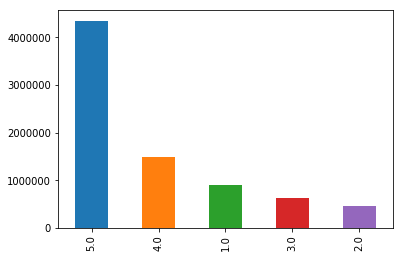

In [57]:
rating_df['rating'].value_counts().plot.bar()

# Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings )

In [58]:
counts1 = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(counts1[counts1 >= 50].index)]

In [59]:
rating_df.shape

(125871, 3)

# Split the data randomly into train and test dataset. (For example split it in 70/30 ratio)

In [60]:
train_data, test_data = train_test_split(rating_df, test_size = 0.30, random_state=0)

print train_data.info()
print test_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 88109 entries, 6595853 to 4025040
Data columns (total 3 columns):
user_id    88109 non-null object
prod_id    88109 non-null object
rating     88109 non-null float64
dtypes: float64(1), object(2)
memory usage: 2.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37762 entries, 6730391 to 975289
Data columns (total 3 columns):
user_id    37762 non-null object
prod_id    37762 non-null object
rating     37762 non-null float64
dtypes: float64(1), object(2)
memory usage: 1.2+ MB
None


#  Build Popularity Recommender model

In [61]:
#as we do not have the counts of items sold/rated, every presence of a prod_id in the table is considered as a count and groupby 
#gives total count of item rated. I can not think of any other logic to get the count 

value_counts = train_data['prod_id'].value_counts(dropna=True, sort=True)
train_df = value_counts.rename_axis('unique_values').reset_index(name='counts')

train_prod_ratedcount=train_df['counts'].sum()



In [62]:
#calculate the % of rating based on count of product identifier present in the dateset, as grouped above, and calculated below

train_df['percentage']=train_df['counts'].div(train_prod_ratedcount)*100

#song_grouped.sort_values(['listen_count', 'song'], ascending = [0,1])
train_df.sort_values(['counts','percentage'],ascending=[0,1])
train_df.head(5)

item_popularity_df =rating_df.groupby('prod_id')['rating'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,prod_id,rating
0,B003ES5ZUU,895.0
1,B0088CJT4U,869.0
2,B000N99BBC,797.0
3,B007WTAJTO,771.0
4,B00829TIEK,661.0
5,B00829THK0,605.0
6,B008DWCRQW,561.0
7,B004CLYEDC,551.0
8,B002R5AM7C,528.0
9,B002V88HFE,498.0


In [63]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = rating_df.set_index('user_id')
interactions_train_indexed_df = train_data.set_index('user_id')
interactions_test_indexed_df = test_data.set_index('user_id')

def get_items_interacted(person_id, rating_df):
    # Get the user's data and merge in the movie information.
    interacted_items = rating_df.loc[person_id]['prod_id']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [64]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(rating_df['prod_id'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['prod_id']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['prod_id'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['prod_id'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=0.01)

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['prod_id'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['prod_id'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator() 

In [65]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['prod_id'].isin(items_to_ignore)] \
                               .sort_values('rating', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'prod_id', 
                                                          right_on = 'prod_id')[[ 'prod_id']]


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, rating_df)

In [66]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
1539 users processed

Global metrics:
{'recall@5': 0.3525501827233727, 'modelName': 'Popularity', 'recall@10': 0.48411101106932897}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
403,A5JLAU2ARJ0BO,33,26,159,0.207547,0.163522
158,ADLVFFE4VBT8,94,80,152,0.618421,0.526316
162,A3OXHLG6DIBRW8,58,38,152,0.381579,0.250000
152,A6FIAB28IS79,46,32,141,0.326241,0.226950
4,A680RUE1FDO8B,50,44,118,0.423729,0.372881
804,A1ODOGXEYECQQ8,68,43,117,0.581197,0.367521
60,A2AY4YUOX2N1BQ,24,9,97,0.247423,0.092784
151,A23GFTVIETX7DS,57,33,97,0.587629,0.340206
167,A36K2N527TXXJN,51,35,93,0.548387,0.376344
258,A22CW0ZHY3NJH8,54,42,91,0.593407,0.461538


In [67]:
#Here we perform the evaluation of the Popularity model, according to the method 
#It achieved the Recall@5 of 0.3525, which means that about 35% of interacted items in train set were 
#ranked by Popularity model among the top-5 items (from lists with 100 random items). And Recall@10 was even higher (48%),


# Build Collaborative Filtering model.

In [68]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = train_data.pivot(index='user_id', 
                                                          columns='prod_id', 
                                                          values='rating').fillna(0)

users_items_pivot_matrix_df.head(10)

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501776,1400532620,1400532655,1400599997,1400698987,...,B00L26YDA4,B00L3YHF6O,B00L403O94,B00L5YZCCG,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGQ6HL8,B00LI4ZZO8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10H24TDLK2VDP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10NMELR4KX0J6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10O7THJ2O20AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10PEXB6XAQ5XF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()


users_items_pivot_matrix[:10]
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

C:\Users\RB00001\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


['A100UD67AHFODS',
 'A100WO06OQR8BQ',
 'A105S56ODHGJEK',
 'A105TOJ6LTVMBG',
 'A10AFVU66A79Y1',
 'A10H24TDLK2VDP',
 'A10NMELR4KX0J6',
 'A10O7THJ2O20AG',
 'A10PEXB6XAQ5XF',
 'A10X9ME6R66JDX']

In [70]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
print U.shape
print Vt.shape
sigma = np.diag(sigma)
sigma.shape

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

(1540L, 15L)
(15L, 38226L)


array([[ 2.70112484e-03,  1.98622579e-03,  7.25939763e-04, ...,
         5.50084560e-03,  7.59788254e-02,  1.00344163e-02],
       [ 2.85366176e-03,  7.98805097e-04,  4.11518201e-04, ...,
         1.21933135e-03, -1.72731733e-02,  5.83698207e-03],
       [-1.09563904e-03, -4.52320683e-04, -2.53538545e-04, ...,
        -2.06298489e-03,  1.22906531e-02,  3.91656932e-03],
       ...,
       [ 5.79218014e-03,  7.31703048e-03,  7.24069565e-04, ...,
         4.04206187e-02,  3.32390077e-01,  1.35018182e-01],
       [ 5.03426988e-04,  2.78997779e-04,  1.94919635e-04, ...,
         1.13332059e-03,  8.45221365e-03,  1.58701725e-03],
       [ 7.27369940e-04,  5.94561394e-04,  1.00365397e-04, ...,
        -1.95097420e-04, -1.02694845e-02,  5.02798676e-04]])

In [71]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
prod_id,,,,,,,,,,,,,,,,,,,,,
0594451647,0.002701,0.002854,-0.001096,0.002084,0.000768,0.000093,0.002429,0.006932,0.001764,0.004312,...,0.001632,0.001273,0.001905,0.003265,0.003377,0.002136,0.001330,0.005792,0.000503,0.000727
0594481813,0.001986,0.000799,-0.000452,0.003365,0.000444,0.000783,0.004255,0.008395,0.001890,0.005426,...,0.001600,0.000874,0.000591,0.003440,0.005142,0.002590,0.002069,0.007317,0.000279,0.000595
0970407998,0.000726,0.000412,-0.000254,0.000413,0.000161,0.000081,0.000604,0.001890,0.000293,0.000909,...,0.000315,0.000182,0.000312,0.000791,0.001073,0.000400,0.000353,0.000724,0.000195,0.000100
0972683275,0.004275,0.012523,0.024367,0.011411,0.008673,0.001507,0.012769,0.041788,0.027811,0.028983,...,0.004723,0.006627,-0.005515,0.012214,0.003719,0.013974,0.006591,0.000798,-0.000422,0.004880
1400501466,0.000181,0.006173,0.008057,0.002008,0.003388,0.004699,0.001388,0.004591,0.008245,0.005463,...,0.001842,0.002475,0.002954,0.001850,0.006172,0.002623,0.000649,0.005303,0.001500,0.002016
1400501776,0.003113,0.019333,0.005889,-0.000275,0.004749,0.012684,-0.003337,0.001207,0.008442,0.003938,...,0.002820,0.004269,0.012031,0.002045,0.015585,-0.000154,-0.000556,0.023165,0.003897,0.004289
1400532620,0.000824,0.000587,0.005837,0.000164,0.001817,0.000515,0.000458,0.002159,0.003590,0.001141,...,0.000004,0.000280,-0.000333,0.000323,0.001029,0.000076,-0.000223,-0.005987,0.000417,0.000050
1400532655,0.013712,0.006718,-0.003341,0.004286,0.001802,-0.004653,0.007281,0.019853,0.003805,0.011252,...,0.002488,0.002589,0.001056,0.008020,0.011008,0.004559,0.001910,0.031629,0.006043,0.002366
1400599997,0.002833,0.007704,0.008474,0.000485,0.004392,0.008684,0.000073,0.001489,0.007071,0.001896,...,0.002022,0.001313,0.008563,0.001907,0.011603,-0.000428,0.000193,-0.003511,0.002903,0.001014


In [72]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)



,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
prod_id,,,,,,,,,,,,,,,,,,,,,
0594451647,0.002701,0.002854,-0.001096,0.002084,0.000768,0.000093,0.002429,0.006932,0.001764,0.004312,...,0.001632,0.001273,0.001905,0.003265,0.003377,0.002136,0.001330,0.005792,0.000503,0.000727
0594481813,0.001986,0.000799,-0.000452,0.003365,0.000444,0.000783,0.004255,0.008395,0.001890,0.005426,...,0.001600,0.000874,0.000591,0.003440,0.005142,0.002590,0.002069,0.007317,0.000279,0.000595
0970407998,0.000726,0.000412,-0.000254,0.000413,0.000161,0.000081,0.000604,0.001890,0.000293,0.000909,...,0.000315,0.000182,0.000312,0.000791,0.001073,0.000400,0.000353,0.000724,0.000195,0.000100
0972683275,0.004275,0.012523,0.024367,0.011411,0.008673,0.001507,0.012769,0.041788,0.027811,0.028983,...,0.004723,0.006627,-0.005515,0.012214,0.003719,0.013974,0.006591,0.000798,-0.000422,0.004880
1400501466,0.000181,0.006173,0.008057,0.002008,0.003388,0.004699,0.001388,0.004591,0.008245,0.005463,...,0.001842,0.002475,0.002954,0.001850,0.006172,0.002623,0.000649,0.005303,0.001500,0.002016
1400501776,0.003113,0.019333,0.005889,-0.000275,0.004749,0.012684,-0.003337,0.001207,0.008442,0.003938,...,0.002820,0.004269,0.012031,0.002045,0.015585,-0.000154,-0.000556,0.023165,0.003897,0.004289
1400532620,0.000824,0.000587,0.005837,0.000164,0.001817,0.000515,0.000458,0.002159,0.003590,0.001141,...,0.000004,0.000280,-0.000333,0.000323,0.001029,0.000076,-0.000223,-0.005987,0.000417,0.000050
1400532655,0.013712,0.006718,-0.003341,0.004286,0.001802,-0.004653,0.007281,0.019853,0.003805,0.011252,...,0.002488,0.002589,0.001056,0.008020,0.011008,0.004559,0.001910,0.031629,0.006043,0.002366
1400599997,0.002833,0.007704,0.008474,0.000485,0.004392,0.008684,0.000073,0.001489,0.007071,0.001896,...,0.002022,0.001313,0.008563,0.001907,0.011603,-0.000428,0.000193,-0.003511,0.002903,0.001014


In [73]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(rating_df['prod_id'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['prod_id']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['prod_id'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['prod_id'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=100)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=.01)

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['prod_id'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['prod_id'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()  

In [74]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['prod_id'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'prod_id', 
                                                          right_on = 'prod_id')[['prod_id']]


        return recommendations_df
    


In [75]:
cf_recommender_model = CFRecommender(cf_preds_df, train_data)

In [76]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
1539 users processed

Global metrics:
{'recall@5': 0.07459880302950056, 'modelName': 'Collaborative Filtering', 'recall@10': 0.07459880302950056}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
403,A5JLAU2ARJ0BO,2,2,159,0.012579,0.012579
158,ADLVFFE4VBT8,7,7,152,0.046053,0.046053
162,A3OXHLG6DIBRW8,4,4,152,0.026316,0.026316
152,A6FIAB28IS79,6,6,141,0.042553,0.042553
4,A680RUE1FDO8B,1,1,118,0.008475,0.008475
804,A1ODOGXEYECQQ8,13,13,117,0.111111,0.111111
60,A2AY4YUOX2N1BQ,2,2,97,0.020619,0.020619
151,A23GFTVIETX7DS,6,6,97,0.061856,0.061856
167,A36K2N527TXXJN,8,8,93,0.086022,0.086022
258,A22CW0ZHY3NJH8,9,9,91,0.098901,0.098901


# Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits,we will recommend 5 new products.

In [77]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(rating_df, how = 'left', 
                                                      left_on = 'prod_id', 
                                                      right_on = 'prod_id') \
                          .sort_values('user_id', ascending = False)[['prod_id']]
                                                                          

In [78]:
inspect_interactions('A105S56ODHGJEK', test_set=False).head(5)

#we supply 1 user and get 20 recommendation for the user ID A105S56ODHGJEK

,prod_id
1091,B000N99BBC
21,B00DQZOD8Q
668,B00CL8F98W
219,B00G6CLNCK
202,B002OEBILK


# Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

In [79]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics]).set_index('modelName')
global_metrics_df

,recall@10,recall@5
modelName,,
Popularity,0.484111,0.352550
Collaborative Filtering,0.074599,0.074599


# Summarise your insights

In [80]:
# for this data set, contentbased works better than collaborative 